In [1]:
# import dependencies
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.layers import Softmax
#from tensorflow.python.platform import build_info as tf_build_info
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import onnxruntime
import os, random
import platform
import time

print("python version:", platform.python_version())
print("keras version: {0}, backend: {1}".format(tf.keras.__version__, K.backend()))
print("tensorflow version: {}".format(tf.__version__))
print('ONNX: {}'.format(onnxruntime.get_device()))

python version: 3.7.6
keras version: 2.2.4-tf, backend: tensorflow
tensorflow version: 2.1.0
ONNX: CPU


In [2]:
# if tf.test.gpu_device_name():
#     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
# else:
#     print("Please install GPU version of TF")
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("CUDA: {0} | CUDnn: {1}".format(tf_build_info.cuda_version_number,  tf_build_info.cudnn_version_number))

In [3]:
# load model
t0_keras = time.time()
keras_model = load_model(r'model/vgg19gap_checkpoint.h5')
print('Keras Model Load Time: {:.2f} seconds'.format(time.time() - t0_keras))
t0_onnx = time.time()
onnx_model = 'model/vgg19gap_checkpoint.onnx'
onnx_model = onnxruntime.InferenceSession(onnx_model)
print('ONNX Model Load Time: {:.2f} seconds'.format(time.time() - t0_onnx))

Keras Model Load Time: 8.47 seconds
ONNX Model Load Time: 0.97 seconds


In [4]:
def keras_inference(image_path, model):
    # preprocess image
    test_image = image.load_img(image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image).astype('float32')*1/255
    test_image = np.expand_dims(test_image,axis=0)

    with tf.device("cpu:0"):
        # inference keras model
        t0 = time.time()
        test_image = model.predict(test_image)
        t1 = time.time() - t0
        t1 = round(t1, 3)
    
    Effusion = test_image[0, 0] * 100
    No_Finding = test_image[0, 1] * 100
    true_label = os.path.split(os.path.dirname(image_path))[-1]

    return Effusion, No_Finding, true_label, t1

In [5]:
def onnx_inference(image_path, model):
    # preprocess image
    test_image = image.load_img(image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image).astype('float32')*1/255
    test_image  = np.expand_dims(test_image, axis=0)

    # inference onnx model
    test_image = test_image if isinstance(test_image, list) else [test_image]
    test_image = dict([(input.name, test_image[n]) for n, input in enumerate(onnx_model.get_inputs())])
    t0 = time.time()
    test_image = model.run(None, test_image)[0]
    t1 = time.time() - t0
    t1 = round(t1, 3)
    
    # pred = np.squeeze(pred_onnx)
    # # softmax
    # softmax = Softmax()
    # pred_soft = softmax(pred)

    Effusion = test_image[0, 0] * 100
    No_Finding = test_image[0, 1] * 100
    true_label = os.path.split(os.path.dirname(image_path))[-1]

    return Effusion, No_Finding, true_label, t1

True Label : Effusion

Keras Pediction :
No Finding - 15.64%
Effusion - 84.36%
Keras Model Inference Time (CPU): 0.258 seconds

ONNX Pediction :
No Finding - 15.64%
Effusion - 84.36%
ONNX Model Inference Time (CPU): 0.186 seconds


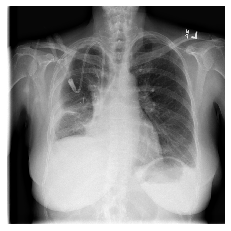

In [8]:
# select random image from directory
No_Finding = random.choice(os.listdir(r"dataset\test_set\No Finding"))
Effusion = random.choice(os.listdir(r"dataset\test_set\Effusion"))
image_path = random.choice([Effusion, No_Finding])

# path of image file
for root, dirs, files in os.walk(r'D:\Data\Documents\Rafi\Python Scripts\Keras_TF_ONNX'):
    for name in files:
        if name == image_path:
            image_path = os.path.abspath(os.path.join(root, name))

# plot predictions
t1 = keras_inference(image_path, keras_model)[3]
t2 = onnx_inference(image_path, onnx_model)[3]

Effusion_Keras = round(keras_inference(image_path, keras_model)[0], 2)
No_Finding_Keras  = round(keras_inference(image_path, keras_model)[1], 2)

Effusion_ONNX = round(onnx_inference(image_path, onnx_model)[0], 2)
No_Finding_ONNX  = round(onnx_inference(image_path, onnx_model)[1], 2)

true_label = os.path.split(os.path.dirname(image_path))[-1]

plot_image = mpimg.imread(image_path)
plt.imshow(plot_image, cmap="gray")
plt.axis('off')

print('True Label :', true_label)
print('')
print('Keras Pediction :')
print('No Finding - ', No_Finding_Keras,'%', sep = '')
print('Effusion - ', Effusion_Keras,'%', sep = '')
print('Keras Model Inference Time (CPU): {} seconds'.format(t1))
print('')
print('ONNX Pediction :')
print('No Finding - ', No_Finding_ONNX,'%', sep = '')
print('Effusion - ', Effusion_ONNX,'%', sep = '')
print('ONNX Model Inference Time (CPU): {} seconds'.format(t2))